In [1]:
from neuralnet.first_version import *

In [2]:
from numpy import ndarray

class SoftmaxCrossEntropy(Loss):
    def __init__(self, eps: float=1e-9):
        super().__init__()
        self.eps = eps
    
    def _output(self) -> float:
        softmax_preds = self.softmax(self.prediction, axis=1)
        
        self.softmax_preds = np.clip(softmax_preds, self.eps, 1-self.eps)
        
        softmax_cross_entropy_loss = (-1.0* self.target * np.log(self.softmax_preds))
        
        return np.sum(softmax_cross_entropy_loss) / self.prediction.shape[0]
    
    def _input_grad(self) -> ndarray:
        return (self.softmax_preds - self.target) / self.prediction.shape[0]
    
    def softmax(self, x, axis=None):
        return np.exp(x) / np.sum(np.exp(x), axis=axis, keepdims = True)

In [3]:
def relu(x):
    return np.maximum(x,np.zeros_like(x))

def relu_derivative(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x

Text(0, 0.5, '$ReLU(x)$')

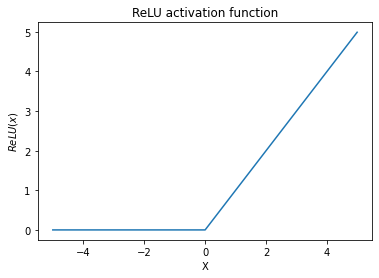

In [4]:
import matplotlib.pyplot as plt
x = np.arange(-5, 5, 0.01)
plt.plot(x, relu(x))
# plt.plot(x, relu_derivative(x))
plt.title("ReLU activation function")
plt.xlabel("X")
plt.ylabel("$ReLU(x)$")

In [5]:
class Tanh(Operation):
    def __init__(self):
        super().__init__()
    
    def _output(self) -> ndarray:
        return np.tanh(self.input_)
    
    def _input_grad(self, output_grad: ndarray) -> ndarray:
        return output_grad * (1-self.output*self.output)

In [6]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version = 1, cache = True)
mnist.target = mnist.target.astype(int)

X_train = mnist['data'][:60000]
y_train = mnist['target'][:60000]

X_test = mnist['data'][60000:]
y_test = mnist['target'][60000:]

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
from sklearn import preprocessing
onehot = preprocessing.OneHotEncoder()

#sklearn expects a 2D array thus we have to reshape to (-1, 1)
y_train_encode = onehot.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test_encode = onehot.fit_transform(y_test.reshape(-1, 1)).toarray()

print(y_train_encode.shape, y_test_encode.shape)

(60000, 10) (10000, 10)


In [9]:
from sklearn.metrics import accuracy_score

def calc_accuracy(model, X_test, y_test):    
    #getting the accuracy score with testing data
    preds = model.forward(X_test)
    preds = np.argmax(preds, axis=1)
    print("Accuracy: ", accuracy_score(y_test, preds))

In [10]:
model = NeuralNetwork(
    layers = [Dense(neurons=89,activation=Tanh()),
             Dense(neurons=10,activation=Sigmoid())],
    loss = MeanSquaredError(),
    seed = 20200720)

In [11]:
trainer = Trainer(model, SGD(0.1))
trainer.fit(X_train, y_train_encode, X_test, y_test_encode, epochs = 50, eval_every = 10, seed=20200720, batch_size=60)

calc_accuracy(model, X_test, y_test)

Validation loss after 10 epochs is 0.300
Validation loss after 20 epochs is 0.245
Validation loss after 30 epochs is 0.225
Validation loss after 40 epochs is 0.216
Validation loss after 50 epochs is 0.210
Accuracy:  0.8758


In [12]:
model = NeuralNetwork(
    layers=[Dense(neurons=89,activation=Tanh()),
           Dense(neurons=10,activation=Linear())],
    loss = SoftmaxCrossEntropy(),
    seed=20200720)

In [13]:
trainer = Trainer(model,SGD(0.1))
trainer.fit(X_train, y_train_encode, X_test, y_test_encode,
           epochs= 50,
           eval_every = 10,
           seed = 20200720,
           batch_size = 60)

calc_accuracy(model, X_test, y_test)

Validation loss after 10 epochs is 0.413
Validation loss after 20 epochs is 0.390
Validation loss after 30 epochs is 0.384
Loss increased after epoch 40, final loss was 0.384, using the model from epoch 30
Accuracy:  0.8898


In [17]:
class SGDMomentum(Optimizer):
    def __init__(self, lr: float = 0.01, momentum: float = 0.9):
        super().__init__(lr)
        self.momentum = momentum
        self.first = True
    
    def step(self):
        if self.first:
            self.velocities = [np.zeros_like(param) for param in self.net.params()]
            self.first = False
            
        for (param, param_grad, velocity) in zip(self.net.params(), self.net.param_grads(), self.velocities):
            self._update_rule(param=param, grad=param_grad,velocity=velocity)
        
    def _update_rule(self,**kwargs):
        kwargs['velocity'] *= self.momentum
        kwargs['velocity'] += self.lr * kwargs['grad']
        kwargs['param'] -= kwargs['velocity']

In [18]:
model = NeuralNetwork(layers = [Dense(neurons=89, activation=Tanh()),
                               Dense(neurons=10, activation=Linear())],
                      loss = SoftmaxCrossEntropy(),
                      seed = 20200720)

trainer = Trainer(model, SGDMomentum(lr=0.1, momentum=0.9))
trainer.fit(X_train, y_train_encode, X_test, y_test_encode, 
            epochs = 50,
            eval_every = 10,
            seed = 20200720,
            batch_size = 60)

calc_accuracy(model, X_test, y_test)

Validation loss after 10 epochs is 0.349
Loss increased after epoch 20, final loss was 0.349, using the model from epoch 10
Accuracy:  0.9156


In [19]:
class Optimizer(object):
    def __init__(self,
                 lr: float = 0.01,
                 final_lr: float = 0,
                 decay_type: str = 'exponential'):
        self.lr = lr
        self.final_lr = final_lr  #<----added
        self.decay_type = decay_type #<----added

    def _setup_decay(self):  #<----added

        if not self.decay_type:
            return
        elif self.decay_type == 'exponential':
            self.decay_per_epoch = np.power(self.final_lr / self.lr,
                                       1.0 / (self.max_epochs - 1))
        elif self.decay_type == 'linear':
            self.decay_per_epoch = (self.lr - self.final_lr) / (self.max_epochs - 1)

    def _decay_lr(self): #<----added

        if not self.decay_type:
            return

        if self.decay_type == 'exponential':
            self.lr *= self.decay_per_epoch

        elif self.decay_type == 'linear':
            self.lr -= self.decay_per_epoch

    def step(self, epoch: int = 0):  #<----added epoch info

        for (param, param_grad) in zip(self.net.params(),
                                       self.net.param_grads()):
            self._update_rule(param=param,
                              grad=param_grad)

    def _update_rule(self, **kwargs):
        raise NotImplementedError()

In [20]:
class SGDMomentum(Optimizer):
    def __init__(self,
                 lr: float = 0.01,
                 final_lr: float = 0,   #<----added
                 decay_type: str = None,   #<------added
                 momentum: float = 0.9):
        super().__init__(lr, final_lr, decay_type)   #<---changed
        self.momentum = momentum
        self.first = True

    def step(self):
        if self.first:
            self.velocities = [np.zeros_like(param)
                               for param in self.net.params()]
            self.first = False

        for (param, param_grad, velocity) in zip(self.net.params(),
                                                 self.net.param_grads(),
                                                 self.velocities):
            self._update_rule(param=param,
                              grad=param_grad,
                              velocity=velocity)

    def _update_rule(self, **kwargs):

        # Update velocity
        kwargs['velocity'] *= self.momentum
        kwargs['velocity'] += self.lr * kwargs['grad']

        # Use this to update parameters
        kwargs['param'] -= kwargs['velocity']

In [21]:
from copy import deepcopy
from typing import Tuple

class Trainer(object):
    #NeuralNetwork and Optimizer as attributes
    def __init__(self,
                 net: NeuralNetwork,
                 optim: Optimizer):
        #Requires a neural network and an optimizer in order for 
        #training to occur. 
        self.net = net
        self.optim = optim
        self.best_loss = 1e9  #use for comparing the least amount of loss
        
        #Assign the neural network as an instance variable to 
        #the optimizer when the code runs
        setattr(self.optim, 'net', self.net)
    

    # helper function for shuffling
    def permute_data(self, X, y):
        perm = np.random.permutation(X.shape[0])
        return X[perm], y[perm]

    # helper function for generating batches
    def generate_batches(self,
                         X: ndarray,
                         y: ndarray,
                         size: int = 32) -> Tuple[ndarray]:
        #X and y should have same number of rows
        assert X.shape[0] == y.shape[0]

        N = X.shape[0]

        for i in range(0, N, size):
            X_batch, y_batch = X[i:i+size], y[i:i+size]
            #return a generator that can be loop
            yield X_batch, y_batch

            
    def fit(self, X_train: ndarray, y_train: ndarray,
            X_test: ndarray, y_test: ndarray,
            epochs: int=100,
            eval_every: int=10,
            batch_size: int=32,
            seed: int = 20200720,
            restart: bool = True):
        
        
        setattr(self.optim, 'max_epochs', epochs)  #<----added
        self.optim._setup_decay() #<----added

        np.random.seed(seed)
        
        #for resetting
        if restart:
            for layer in self.net.layers:
                layer.first = True

            self.best_loss = 1e9
        
        #Fits the neural network on the training data for a certain 
        #number of epochs.
        for e in range(epochs):
            
            if (e+1) % eval_every == 0:
                
                # for early stopping
                # deepcopy is a hardcopy function that make sure it construct a new object (copy() is a shallow copy)
                last_model = deepcopy(self.net)

            X_train, y_train = self.permute_data(X_train, y_train)

            batch_generator = self.generate_batches(X_train, y_train,
                                                    batch_size)

            for (X_batch, y_batch) in batch_generator:

                self.net.train_batch(X_batch, y_batch)

                self.optim.step()
            
            #Every "eval_every" epochs, it evaluated the neural network 
            #on the testing data.
            if (e+1) % eval_every == 0:

                test_preds = self.net.forward(X_test)
                loss = self.net.loss.forward(test_preds, y_test)

                if loss < self.best_loss:
                    print(f"Validation loss after {e+1} epochs is {loss:.3f}")
                    self.best_loss = loss
                #if the validation loss is not lower, it stop and perform early stopping
                else:
                    print(f"""Loss increased after epoch {e+1}, final loss was {self.best_loss:.3f}, using the model from epoch {e+1-eval_every}""")
                    self.net = last_model
                    # ensure self.optim is still updating self.net
                    setattr(self.optim, 'net', self.net)
                    break
            
            #call this at the end of each epoch
            if self.optim.final_lr:  #<------added
                self.optim._decay_lr()   #<-----added

In [22]:
model = NeuralNetwork(
    layers=[Dense(neurons=89, 
                  activation=Tanh()),
            Dense(neurons=10, 
                  activation=Linear())],
            loss = SoftmaxCrossEntropy(), 
seed=20200720)

trainer = Trainer(model, SGDMomentum(lr=0.2, momentum=0.9,
                                    final_lr=0.05, decay_type='exponential'))
trainer.fit(X_train, y_train_encode, X_test, y_test_encode,
            epochs = 50,
            eval_every = 10,
            seed=20200720,
            batch_size=60)

calc_accuracy(model, X_test, y_test)

Validation loss after 10 epochs is 0.323
Validation loss after 20 epochs is 0.306
Loss increased after epoch 30, final loss was 0.306, using the model from epoch 20
Accuracy:  0.9336
